In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torch.nn as nn
from srcnn_model import SRCNN, SRCNN2, SRCNN3, SRCNN6
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))
from utils import get_split_datapaths, psnr, init_logging
from dataloader import PassiveMicrowaveDataset
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import cv2
from torchvision.transforms import ToTensor

from datetime import datetime

In [2]:
train_paths, val_paths, test_paths = get_split_datapaths()

2025-03-27 16:07:23,076 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-03-27 16:07:23,077 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-03-27 16:07:23,077 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/01 does not exist. Skipping...
2025-03-27 16:07:23,077 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/02 does not exist. Skipping...
2025-03-27 16:07:23,078 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/03 does not exist. Skipping...
2025-03-27 16:07:23,078 - root - INFO - Warning: Directory /lustre/storeB/p

In [3]:
# Initialize test dataset with normalization
test_dataset = PassiveMicrowaveDataset(test_paths, transform=ToTensor(), normalize=True, use_bicubic=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [4]:

logger = init_logging()
    # Load model
model_pth = "trained_models/srcnn_model2_24h_batchsize8_samplesall_normalized.pth"

In [5]:

def assess_model(model_pth):
    if "model1" in model_pth.split("_"):
        model = SRCNN()
    elif "model2" in model_pth.split("_"):
        model = SRCNN2()
    elif "model3" in model_pth.split("_"):
        model = SRCNN3()
    elif "model6" in model_pth.split("_"):
        model = SRCNN6()

    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Move model to device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()

    test_loss = 0
    total_psnr = 0
    total_psnr_v = 0
    total_psnr_h = 0

    total_psnr_baseline = 0
    total_psnr_baseline_v = 0
    total_psnr_baseline_h = 0

    num_samples = 0

    with torch.no_grad():
        for low_res, high_res in test_loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            outputs = model(low_res)

            # Denormalize before computing loss and PSNR
            outputs = test_dataset.denormalize(outputs)
            high_res = test_dataset.denormalize(high_res)
            low_res = test_dataset.denormalize(low_res)

            loss = criterion(outputs, high_res)
            test_loss += loss.item()

            # Compute PSNR for each image in the batch
            # batch_psnr = 0
            batch_psnr_v = 0
            batch_psnr_h = 0

            # batch_psnr_baseline = 0
            batch_psnr_baseline_v = 0
            batch_psnr_baseline_h = 0

            for i in range(len(outputs)):
                # psnr_value = psnr(outputs[i], high_res[i])  # Model output vs ground truth
                psnr_value_v = psnr(outputs[i][0], high_res[i][0], pol="V")  # Model output vs ground truth for V pol
                psnr_value_h = psnr(outputs[i][1], high_res[i][1], pol ="H")  # Model output vs ground truth for H pol

                # psnr_baseline_value = psnr(low_res[i], high_res[i])  # Bicubic low res vs ground truth 
                psnr_baseline_value_v = psnr(low_res[i][0], high_res[i][0], pol="V")  # Bicubic low res vs ground truth for V pol
                psnr_baseline_value_h = psnr(low_res[i][1], high_res[i][1], pol="H")  # Bicubic low res vs ground truth for H pol

                # batch_psnr += psnr_value.item()
                batch_psnr_v += psnr_value_v.item()
                batch_psnr_h += psnr_value_h.item()

                # batch_psnr_baseline += psnr_baseline_value.item()
                batch_psnr_baseline_v += psnr_baseline_value_v.item()
                batch_psnr_baseline_h += psnr_baseline_value_h.item()


            # total_psnr += batch_psnr
            total_psnr_v += batch_psnr_v
            total_psnr_h += batch_psnr_h

            # total_psnr_baseline += batch_psnr_baseline
            total_psnr_baseline_v += batch_psnr_baseline_v
            total_psnr_baseline_h += batch_psnr_baseline_h


            num_samples += len(outputs)

    # Compute final metrics
    # average_psnr = total_psnr / num_samples if num_samples > 0 else 0
    # average_psnr_baseline = total_psnr_baseline / num_samples if num_samples > 0 else 0
    average_psnr_v = total_psnr_v / num_samples if num_samples > 0 else 0
    average_psnr_baseline_v = total_psnr_baseline_v / num_samples if num_samples > 0 else 0

    average_psnr_h = total_psnr_h / num_samples if num_samples > 0 else 0
    average_psnr_baseline_h = total_psnr_baseline_h / num_samples if num_samples > 0 else 0

    # Log test results
    # logger.info(f"Test Loss: {test_loss/len(test_loader):.6f}, Test PSNR: {average_psnr:.6f}, Test PSNR Baseline: {average_psnr_baseline:.6f}")
    logger.info(f"Test Loss: {test_loss/len(test_loader):.6f}")
    logger.info(f"V-Pol = Test PSNR: {average_psnr_v:.6f}, Test PSNR Baseline: {average_psnr_baseline_v:.6f}")
    logger.info(f"H-Pol = Test PSNR: {average_psnr_h:.6f}, Test PSNR Baseline: {average_psnr_baseline_h:.6f}")




In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

def plot_single_sample(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output along with the PSNR and MSE.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)

    if "model1" in model_pth.split("_"):
        model = SRCNN()
    elif "model2" in model_pth.split("_"):
        model = SRCNN2()
    elif "model3" in model_pth.split("_"):
        model = SRCNN3()
    elif "model6" in model_pth.split("_"):
        model = SRCNN6()

    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    # Mask to exclude regions where high_res is 0
    mask_v = high_res[0] > 0
    mask_h = high_res[1] > 0

    # Filtered tensors
    filtered_output_v = output[0][mask_v]
    filtered_high_res_v = high_res[0][mask_v]
    filtered_low_res_v = low_res[0][mask_v]

    filtered_output_h = output[1][mask_h]
    filtered_high_res_h = high_res[1][mask_h]
    filtered_low_res_h = low_res[1][mask_h]

    # PSNR computation
    psnr_value_v = psnr(torch.tensor(filtered_high_res_v), torch.tensor(filtered_output_v), pol="V").item()
    psnr_baseline_v = psnr(torch.tensor(filtered_high_res_v), torch.tensor(filtered_low_res_v), pol="V").item()

    psnr_value_h = psnr(torch.tensor(filtered_high_res_h), torch.tensor(filtered_output_h), pol="H").item()
    psnr_baseline_h = psnr(torch.tensor(filtered_high_res_h), torch.tensor(filtered_low_res_h), pol="H").item()

    # SSIM computation
    ssim_low_res_v = ssim(filtered_high_res_v, filtered_low_res_v, data_range=filtered_high_res_v.max() - filtered_high_res_v.min())
    ssim_low_res_h = ssim(filtered_high_res_h, filtered_low_res_h, data_range=filtered_high_res_h.max() - filtered_high_res_h.min())

    ssim_output_v = ssim(filtered_high_res_v, filtered_output_v, data_range=filtered_high_res_v.max() - filtered_high_res_v.min())
    ssim_output_h = ssim(filtered_high_res_h, filtered_output_h, data_range=filtered_high_res_h.max() - filtered_high_res_h.min())

    # # Compute PSNR and MSE # INCLUDING ZEROS HERE 
    # # mse_value = torch.nn.functional.mse_loss(torch.tensor(output), torch.tensor(high_res)).item()
    # psnr_value_v = psnr(torch.tensor(output[0]), torch.tensor(high_res[0]), pol="V").item()
    # psnr_baseline_v = psnr(torch.tensor(low_res[0]), torch.tensor(high_res[0]), pol="V").item()
    # psnr_value_h = psnr(torch.tensor(output[1]), torch.tensor(high_res[1]), pol="H").item()
    # psnr_baseline_h = psnr(torch.tensor(low_res[1]), torch.tensor(high_res[1]), pol="H").item()
    
    # # SSIM
    # # ssim_original_v = ssim(high_res[0], high_res[0], data_range=high_res[0].max() - high_res[0].min()) # =1
    # # ssim_original_h = ssim(high_res[1], high_res[1], data_range=high_res[1].max() - high_res[1].min()) # =1
    # ssim_low_res_v = ssim(high_res[0], low_res[0], data_range=low_res[0].max() - low_res[0].min())
    # ssim_low_res_h = ssim(high_res[1], low_res[1], data_range=low_res[1].max() - low_res[1].min())
    # ssim_output_v = ssim(high_res[0], output[0], data_range=output[0].max() - output[0].min())
    # ssim_output_h = ssim(high_res[1], output[1], data_range=output[1].max() - output[1].min())

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap='jet', vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res SSMI 37 GHz (Input)")
    axs[0, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_v:.3f}\nSSIM: {ssim_low_res_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 0].transAxes)

    im2 = axs[0, 1].imshow(high_res[0], cmap='jet', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res AMSR 37 GHz (Ground Truth)")

    im3 = axs[0, 2].imshow(output[0], cmap='jet', vmin=v_min, vmax=v_max)  # SRCNN Output
    axs[0, 2].axis('off')
    axs[0, 2].set_title("SRCNN Output")
    axs[0, 2].text(0.7, 0.9, f"PSNR: {psnr_value_v:.3f}\nSSIM: {ssim_output_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 2].transAxes)

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap='jet', vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")
    axs[1, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_h:.3f}\nSSIM: {ssim_low_res_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 0].transAxes)

    im5 = axs[1, 1].imshow(high_res[1], cmap='jet', vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(output[1], cmap='jet', vmin=h_min, vmax=h_max)  # SRCNN Output
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")
    axs[1, 2].text(0.7, 0.9, f"PSNR: {psnr_value_h:.3f}\nSSIM: {ssim_output_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 2].transAxes)

    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.415])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label='Brightness Temperature (K)')
    fig.colorbar(im5, cax=cbar_ax2, label='Brightness Temperature (K)')
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()




**NOTE** All pixels with nan i.e. 0 in LR han HR have low but not 0 values: 1.2296349e+01 -4.2786789e+00  1.3080231e+01


2020-05-24 12:00:00


/tmp/ipykernel_1659970/414058501.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-03-27 16:07:47,348 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-27 16:07:47,348 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-27 16:07:47,352 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-27 16:07:47,352 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-27 16:07:47,356 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-03-27 16:07:47,356 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-03-27 16:07:47,357 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mp

/tmp/ipykernel_1659970/414058501.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


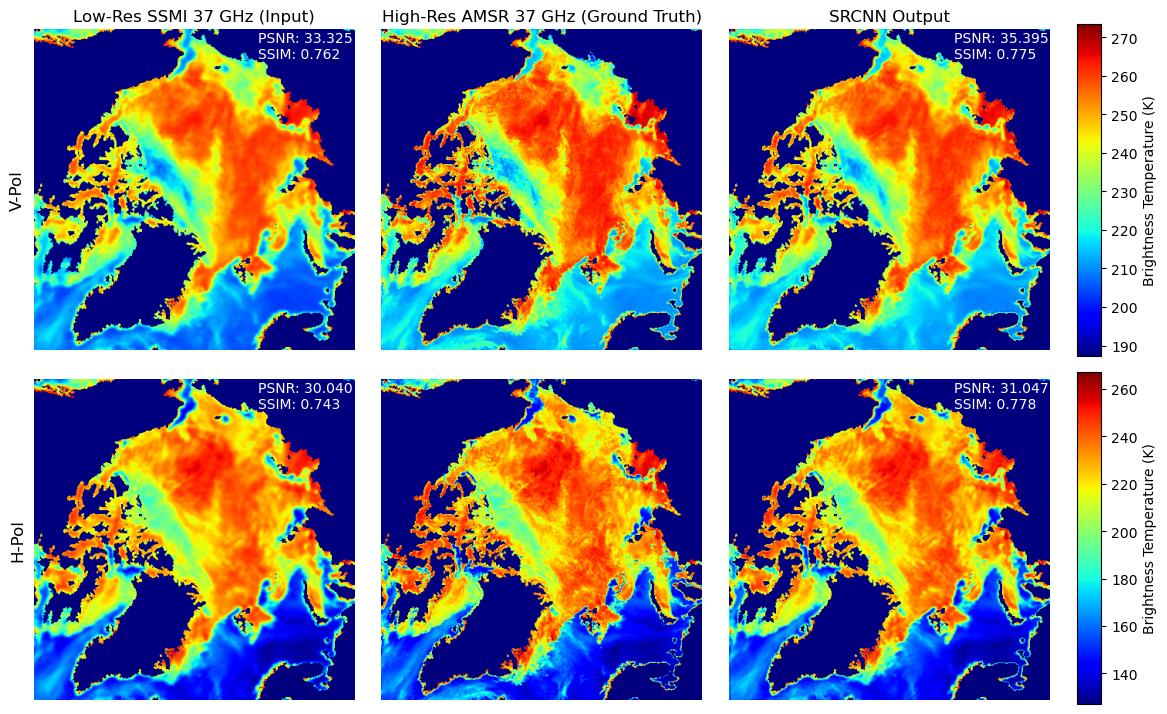

In [7]:
plot_single_sample(model_pth= "trained_models/srcnn_model2_24h_batchsize8_samplesall_normalized.pth",
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=125)
# plt.savefig("../figures/srcnn_model2_24h_batchsize8_samplesall_normalized_2020_05_24.png", bbox_inches="tight")

In [8]:
assess_model(model_pth)

/tmp/ipykernel_1659970/1453960439.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-03-27 16:09:59,635 - root - INFO - Test Loss: 23.015510
2025-03-27 16:09:59,635 - root - INFO - Test Loss: 23.015510
2025-03-27 16:09:59,636 - root - INFO - V-Pol = Test PSNR: 38.999326, Test PSNR Baseline: 35.914288
2025-03-27 16:09:59,636 - root - INFO - V-Pol = Test PSNR: 38.999326, Test PSNR Baseline: 35.914288
2025-03-27 16:09:59,637 - root - INFO - H-Pol = Test PSNR: 34.664440, Test PSNR Baseline: 33.417338
2025-03-27 16:09:59,637 - root - INFO - H-Pol = Test PSNR: 34.664440, Test PSNR Baseline: 33.417338


2020-05-24 12:00:00


/tmp/ipykernel_1659970/414058501.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-03-27 16:10:00,492 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8e9826810>
2025-03-27 16:10:00,492 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8e9826810>
2025-03-27 16:10:00,496 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8eb25bf80>
2025-03-27 16:10:00,496 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8eb25bf80>


/tmp/ipykernel_1659970/414058501.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


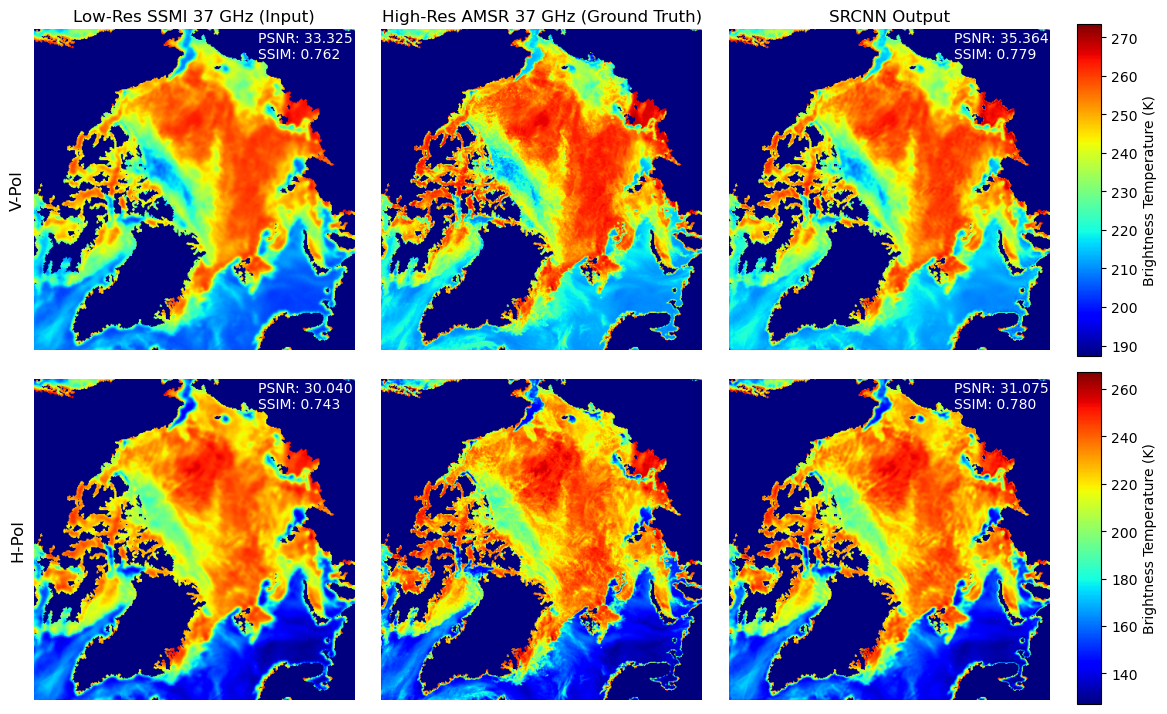

In [9]:
plot_single_sample(model_pth= "trained_models/srcnn_model6_24h_batchsize8_samplesall_normalized.pth",
                test_paths=test_paths,
                test_dataset=test_dataset,
                sample_idx=125)
# plt.savefig("../figures/srcnn_model2_24h_batchsize8_samplesall_normalized_2020_05_24.png", bbox_inches="tight");

In [10]:
assess_model("trained_models/srcnn_model6_24h_batchsize8_samplesall_normalized.pth")

/tmp/ipykernel_1659970/1453960439.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-03-27 16:14:58,938 - root - INFO - Test Loss: 22.732494
2025-03-27 16:14:58,938 - root - INFO - Test Loss: 22.732494
2025-03-27 16:14:58,940 - root - INFO - V-Pol = Test PSNR: 38.995817, Test PSNR Baseline: 35.914288
2025-03-27 16:14:58,940 - root - INFO - V-Pol = Test PSNR: 38.995817, Test PSNR Baseline: 35.914288
2025-03-27 16:14:58,940 - root - INFO - H-Pol = Test PSNR: 34.759217, Test PSNR Baseline: 33.417338
2025-03-27 16:14:58,940 - root - INFO - H-Pol = Test PSNR: 34.759217, Test PSNR Baseline: 33.417338


**NOTE:** Model 2 performs best on V-Pol. Model 6 which is wider, performs marginally worse on V-Pol, but noticeably better on H-Pol, arguably making it a little better overall. 